In [ ]:
!pip install keras==2.2.4

     |████████████████████████████████| 317kB 2.8MB/s 
     |████████████████████████████████| 51kB 5.2MB/s 
  Found existing installation: Keras 2.4.3
    Uninstalling Keras-2.4.3:
      Successfully uninstalled Keras-2.4.3


In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
import tensorflow as tf
print(tf.__version__)

1.15.2


In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-08256c08-312d-14b3-b5c0-5a02cbb6708e)


In [ ]:
from __future__ import division
from __future__ import absolute_import
import random
import pprint
import keras
import sys
import time
import numpy as np
import pickle
import cv2
import random
import copy
import threading
import itertools
import pandas as pd
import os

from matplotlib import pyplot as plt
from keras import backend as K
from keras.optimizers import Adam, SGD
from keras.layers import Input
from keras.models import Model
from keras.utils import generic_utils

Using TensorFlow backend.


# Config Settings

In [ ]:
import math

class Config:

	def __init__(self):

		# Print the process or not
		self.verbose = True

		# Name of base network
		self.network = 'resnet50'

		# setting for data augmentation
		self.use_horizontal_flips = False
		self.use_vertical_flips = False
		self.rot_90 = False

		# anchor box scales
		self.anchor_box_scales = [8, 16, 32, 64]

		# anchor box ratios
		self.anchor_box_ratios = [[1, 1], [1, 2], [2, 1]]

		# size to resize the smallest side of the image
		self.im_size = 600

		# image channel-wise mean to subtract
		self.img_channel_mean = [103.939, 116.779, 123.68]
		self.img_scaling_factor = 1.0

		# stride at the RPN (this depends on the network configuration: VGG16 = 8, ResNet50 = 16)
		self.rpn_stride = 16

		# number of ROIs at once
		self.num_rois = 64

		self.balanced_classes = False

		# scaling the stdev
		self.std_scaling = 4.0
		self.classifier_regr_std = [8.0, 8.0, 4.0, 4.0]

		# overlaps for RPN
		self.rpn_min_overlap = 0.3
		self.rpn_max_overlap = 0.7

		# overlaps for classifier ROIs
		self.classifier_min_overlap = 0.1
		self.classifier_max_overlap = 0.5

		# placeholder for the class mapping, automatically generated by the parser
		self.class_mapping = None

		#location of pretrained weights for the base network 
		# weight files can be found at:
		# https://github.com/fchollet/deep-learning-models/releases/download/v0.2/resnet50_weights_th_dim_ordering_th_kernels_notop.h5
		# https://github.com/fchollet/deep-learning-models/releases/download/v0.2/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5

		self.model_path = None

# Helper

In [ ]:
def union(au, bu, area_intersection):
    """
    a and b should be (x1,y1,x2,y2)
    """
    area_a = (au[2] - au[0]) * (au[3] - au[1])
    area_b = (bu[2] - bu[0]) * (bu[3] - bu[1])
    area_union = area_a + area_b - area_intersection
    return area_union


def intersection(ai, bi):
    """
    a and b should be (x1,y1,x2,y2)
    """
    x = max(ai[0], bi[0])
    y = max(ai[1], bi[1])
    w = min(ai[2], bi[2]) - x
    h = min(ai[3], bi[3]) - y
    if w < 0 or h < 0:
        return 0
    return w*h


def iou(a, b):
    """
    a and b should be (x1,y1,x2,y2)
    """
    if a[0] >= a[2] or a[1] >= a[3] or b[0] >= b[2] or b[1] >= b[3]:
        return 0.0
    I = intersection(a, b)
    U = union(a, b, I)
    return float(I) / float(1e-6 + U)


def get_new_img_size(width, height, img_min_side=600):
    """
    get image dimensions for resizing
    """
    if width <= height:
        f = float(img_min_side) / width
        resized_height = int(f * height)
        resized_width = img_min_side
    else:
        f = float(img_min_side) / height
        resized_width = int(f * width)
        resized_height = img_min_side

    return resized_width, resized_height


class SampleSelector:
    def __init__(self, class_count):
        # ignore classes that have zero samples
        self.classes = [b for b in class_count.keys() if class_count[b] > 0]
        self.class_cycle = itertools.cycle(self.classes)
        self.curr_class = next(self.class_cycle)

    def skip_sample_for_balanced_class(self, img_data):
        class_in_img = False

        for bbox in img_data['bboxes']:
            cls_name = bbox['class']
            if cls_name == self.curr_class:
                class_in_img = True
                self.curr_class = next(self.class_cycle)
                break

        if class_in_img:
            return False
        else:
            return True


def calc_rpn(C, img_data, width, height, resized_width, resized_height, img_length_calc_function):

    downscale = float(C.rpn_stride)
    anchor_sizes = C.anchor_box_scales
    anchor_ratios = C.anchor_box_ratios
    num_anchors = len(anchor_sizes) * len(anchor_ratios)
    n_anchratios = len(anchor_ratios)

    # calculate the output map size based on the network architecture
    (output_width, output_height) = img_length_calc_function(C, resized_width, resized_height)
    output_width, output_height = int(output_width), int(output_height)

    # initialise empty output objectives
    y_rpn_overlap = np.zeros((output_height, output_width, num_anchors))
    y_is_box_valid = np.zeros((output_height, output_width, num_anchors))
    y_rpn_regr = np.zeros((output_height, output_width, num_anchors * 4))

    num_bboxes = len(img_data['bboxes'])
    num_anchors_for_bbox = np.zeros(num_bboxes).astype(int)
    best_anchor_for_bbox = -1*np.ones((num_bboxes, 4)).astype(int)
    best_iou_for_bbox = np.zeros(num_bboxes).astype(np.float32)
    best_x_for_bbox = np.zeros((num_bboxes, 4)).astype(int)
    best_dx_for_bbox = np.zeros((num_bboxes, 4)).astype(np.float32)

    # get the GT box coordinates, and resize to account for image resizing
    gta = np.zeros((num_bboxes, 4))
    for bbox_num, bbox in enumerate(img_data['bboxes']):
        # get the GT box coordinates, and resize to account for image resizing
        gta[bbox_num, 0] = bbox['x1'] * (resized_width / float(width))
        gta[bbox_num, 1] = bbox['x2'] * (resized_width / float(width))
        gta[bbox_num, 2] = bbox['y1'] * (resized_height / float(height))
        gta[bbox_num, 3] = bbox['y2'] * (resized_height / float(height))

    # rpn ground truth
    for anchor_size_idx in range(len(anchor_sizes)):
        for anchor_ratio_idx in range(n_anchratios):
            anchor_x = anchor_sizes[anchor_size_idx] * anchor_ratios[anchor_ratio_idx][0]
            anchor_y = anchor_sizes[anchor_size_idx] * anchor_ratios[anchor_ratio_idx][1]

            for ix in range(output_width):
                # x-coordinates of the current anchor box
                x1_anc = downscale * (ix + 0.5) - anchor_x / 2
                x2_anc = downscale * (ix + 0.5) + anchor_x / 2

                # ignore boxes that go across image boundaries
                if x1_anc < 0 or x2_anc > resized_width:
                    continue

                for jy in range(output_height):
                    # y-coordinates of the current anchor box
                    y1_anc = downscale * (jy + 0.5) - anchor_y / 2
                    y2_anc = downscale * (jy + 0.5) + anchor_y / 2

                    # ignore boxes that go across image boundaries
                    if y1_anc < 0 or y2_anc > resized_height:
                        continue

                    # bbox_type indicates whether an anchor should be a target
                    bbox_type = 'neg'

                    # this is the best IOU for the (x,y) coord and the current anchor
                    # note that this is different from the best IOU for a GT bbox
                    best_iou_for_loc = 0.0

                    for bbox_num in range(num_bboxes):

                        # get IOU of the current GT box and the current anchor box
                        curr_iou = iou([gta[bbox_num, 0], gta[bbox_num, 2], gta[bbox_num, 1], gta[bbox_num, 3]], [x1_anc, y1_anc, x2_anc, y2_anc])
                        # calculate the regression targets if they will be needed
                        if curr_iou > best_iou_for_bbox[bbox_num] or curr_iou > C.rpn_max_overlap:
                            cx = (gta[bbox_num, 0] + gta[bbox_num, 1]) / 2.0
                            cy = (gta[bbox_num, 2] + gta[bbox_num, 3]) / 2.0
                            cxa = (x1_anc + x2_anc)/2.0
                            cya = (y1_anc + y2_anc)/2.0

                            tx = (cx - cxa) / (x2_anc - x1_anc)
                            ty = (cy - cya) / (y2_anc - y1_anc)
                            tw = np.log((gta[bbox_num, 1] - gta[bbox_num, 0]) / (x2_anc - x1_anc))
                            th = np.log((gta[bbox_num, 3] - gta[bbox_num, 2]) / (y2_anc - y1_anc))

                        if img_data['bboxes'][bbox_num]['class'] != 'bg':

                            # all GT boxes should be mapped to an anchor box, so we keep track of which anchor box was best
                            if curr_iou > best_iou_for_bbox[bbox_num]:
                                best_anchor_for_bbox[bbox_num] = [jy, ix, anchor_ratio_idx, anchor_size_idx]
                                best_iou_for_bbox[bbox_num] = curr_iou
                                best_x_for_bbox[bbox_num,:] = [x1_anc, x2_anc, y1_anc, y2_anc]
                                best_dx_for_bbox[bbox_num,:] = [tx, ty, tw, th]

                            # we set the anchor to positive if the IOU is >0.7 (it does not matter if there was another better box, it just indicates overlap)
                            if curr_iou > C.rpn_max_overlap:
                                bbox_type = 'pos'
                                num_anchors_for_bbox[bbox_num] += 1
                                # we update the regression layer target if this IOU is the best for the current (x,y) and anchor position
                                if curr_iou > best_iou_for_loc:
                                    best_iou_for_loc = curr_iou
                                    best_regr = (tx, ty, tw, th)

                            # if the IOU is >0.3 and <0.7, it is ambiguous and no included in the objective
                            if C.rpn_min_overlap < curr_iou < C.rpn_max_overlap:
                                # gray zone between neg and pos
                                if bbox_type != 'pos':
                                    bbox_type = 'neutral'

                    # turn on or off outputs depending on IOUs
                    if bbox_type == 'neg':
                        y_is_box_valid[jy, ix, anchor_ratio_idx + n_anchratios * anchor_size_idx] = 1
                        y_rpn_overlap[jy, ix, anchor_ratio_idx + n_anchratios * anchor_size_idx] = 0
                    elif bbox_type == 'neutral':
                        y_is_box_valid[jy, ix, anchor_ratio_idx + n_anchratios * anchor_size_idx] = 0
                        y_rpn_overlap[jy, ix, anchor_ratio_idx + n_anchratios * anchor_size_idx] = 0
                    elif bbox_type == 'pos':
                        y_is_box_valid[jy, ix, anchor_ratio_idx + n_anchratios * anchor_size_idx] = 1
                        y_rpn_overlap[jy, ix, anchor_ratio_idx + n_anchratios * anchor_size_idx] = 1
                        start = 4 * (anchor_ratio_idx + n_anchratios * anchor_size_idx)
                        y_rpn_regr[jy, ix, start:start+4] = best_regr

    # we ensure that every bbox has at least one positive RPN region
    for idx in range(num_anchors_for_bbox.shape[0]):
        if num_anchors_for_bbox[idx] == 0:
            # no box with an IOU greater than zero ...
            if best_anchor_for_bbox[idx, 0] == -1:
                continue
            y_is_box_valid[
                best_anchor_for_bbox[idx,0], best_anchor_for_bbox[idx,1], best_anchor_for_bbox[idx,2] + n_anchratios *
                best_anchor_for_bbox[idx,3]] = 1
            y_rpn_overlap[
                best_anchor_for_bbox[idx,0], best_anchor_for_bbox[idx,1], best_anchor_for_bbox[idx,2] + n_anchratios *
                best_anchor_for_bbox[idx,3]] = 1
            start = 4 * (best_anchor_for_bbox[idx,2] + n_anchratios * best_anchor_for_bbox[idx,3])
            y_rpn_regr[
                best_anchor_for_bbox[idx,0], best_anchor_for_bbox[idx,1], start:start+4] = best_dx_for_bbox[idx, :]

    y_rpn_overlap = np.transpose(y_rpn_overlap, (2, 0, 1))
    y_rpn_overlap = np.expand_dims(y_rpn_overlap, axis=0)

    y_is_box_valid = np.transpose(y_is_box_valid, (2, 0, 1))
    y_is_box_valid = np.expand_dims(y_is_box_valid, axis=0)

    y_rpn_regr = np.transpose(y_rpn_regr, (2, 0, 1))
    y_rpn_regr = np.expand_dims(y_rpn_regr, axis=0)

    pos_locs = np.where(np.logical_and(y_rpn_overlap[0, :, :, :] == 1, y_is_box_valid[0, :, :, :] == 1))
    neg_locs = np.where(np.logical_and(y_rpn_overlap[0, :, :, :] == 0, y_is_box_valid[0, :, :, :] == 1))

    num_pos = len(pos_locs[0])

    # one issue is that the RPN has many more negative than positive regions, so we turn off some of the negative
    # regions. We also limit it to 256 regions.
    num_regions = 256

    if len(pos_locs[0]) > num_regions/2:
        val_locs = random.sample(range(len(pos_locs[0])), len(pos_locs[0]) - num_regions/2)
        y_is_box_valid[0, pos_locs[0][val_locs], pos_locs[1][val_locs], pos_locs[2][val_locs]] = 0
        num_pos = num_regions/2

    if len(neg_locs[0]) + num_pos > num_regions:
        val_locs = random.sample(range(len(neg_locs[0])), len(neg_locs[0]) - num_pos)
        y_is_box_valid[0, neg_locs[0][val_locs], neg_locs[1][val_locs], neg_locs[2][val_locs]] = 0

    y_rpn_cls = np.concatenate([y_is_box_valid, y_rpn_overlap], axis=1)
    y_rpn_regr = np.concatenate([np.repeat(y_rpn_overlap, 4, axis=1), y_rpn_regr], axis=1)

    return np.copy(y_rpn_cls), np.copy(y_rpn_regr), num_pos


class threadsafe_iter:
    """Takes an iterator/generator and makes it thread-safe by
    serializing call to the `next` method of given iterator/generator.
    """
    def __init__(self, it):
        self.it = it
        self.lock = threading.Lock()

    def __iter__(self):
        return self

    def next(self):
        with self.lock:
            return next(self.it)


def threadsafe_generator(f):
    """
    A decorator that takes a generator function and makes it thread-safe.
    """
    def g(*a, **kw):
        return threadsafe_iter(f(*a, **kw))
    return g


def get_anchor_gt(all_img_data, class_count, C, img_length_calc_function, mode='train'):
    """
    Find ground-truth anchors:
    gt positive anchors: overlap with ground-truth bbox above threshold rpn_max_overlap
    gt negative anchors: overlap with ground-truth bbox below threshold rpn_min_overlap
    do not train anchors with overlap in between
    """
    sample_selector = SampleSelector(class_count)

    while True:
        if mode == 'train':
            np.random.shuffle(all_img_data)

        for img_data in all_img_data:
            try:
                if C.balanced_classes and sample_selector.skip_sample_for_balanced_class(img_data):
                    continue

                # read in image, and optionally add augmentation
                if mode == 'train':
                    img_data_aug, x_img = augment(img_data, C, augment=True)
                else:
                    img_data_aug, x_img = augment(img_data, C, augment=False)
                ''' img_data = {'filepath': '../dataset/PNG_train/00269.png', 'width': 1360, 
                'height': 800, 'bboxes': [{'class': '9', 'x1': 966, 'x2': 990, 'y1': 430, 
                'y2': 454}], 'imageset': 'trainval'} '''

                ''' img_data_aug = {'filepath': '../dataset/PNG_train/00269.png', 'width': 1360, 
                'height': 800, 'bboxes': [{'class': '9', 'x1': 966, 'x2': 990, 'y1': 430, 
                'y2': 454}], 'imageset': 'trainval'} '''

                ''' x_img = RGB image (800, 1360, 3)'''
                
                (width, height) = (img_data_aug['width'], img_data_aug['height'])
                (rows, cols, _) = x_img.shape
                assert cols == width
                assert rows == height

                # get image dimensions for resizing
                (resized_width, resized_height) = get_new_img_size(width, height, C.im_size)
                # resize the image so that smalles side is length = 600 pixel
                x_img = cv2.resize(x_img, (resized_width, resized_height), interpolation=cv2.INTER_CUBIC)
                


                try:
                    y_rpn_cls, y_rpn_regr, num_pos = calc_rpn(C, img_data_aug, width, height, resized_width, resized_height, img_length_calc_function)
                except:
                    continue

                # Zero-center by mean pixel, and preprocess image
                x_img = x_img[:, :, (2, 1, 0)]  # BGR -> RGB
                x_img = x_img.astype(np.float32)
                x_img[:, :, 0] -= C.img_channel_mean[0]
                x_img[:, :, 1] -= C.img_channel_mean[1]
                x_img[:, :, 2] -= C.img_channel_mean[2]

                x_img = np.transpose(x_img, (2, 0, 1))
                x_img = np.expand_dims(x_img, axis=0)

                y_rpn_regr[:, y_rpn_regr.shape[1]//2:, :, :] *= C.std_scaling

                x_img = np.transpose(x_img, (0, 2, 3, 1))
                y_rpn_cls = np.transpose(y_rpn_cls, (0, 2, 3, 1))
                y_rpn_regr = np.transpose(y_rpn_regr, (0, 2, 3, 1))

                yield np.copy(x_img), [np.copy(y_rpn_cls), np.copy(y_rpn_regr)], img_data_aug

            except Exception as e:
                print(e)
                continue

def debug_anchor_gt(all_img_data, class_count, C, img_length_calc_function, mode='train'):
    """
    Find ground-truth anchors:
    gt positive anchors: overlap with ground-truth bbox above threshold rpn_max_overlap
    gt negative anchors: overlap with ground-truth bbox below threshold rpn_min_overlap
    do not train anchors with overlap in between
    """
    sample_selector = SampleSelector(class_count)

    while True:
        if mode == 'train':
            np.random.shuffle(all_img_data)

        for img_data in all_img_data:
            try:
                if C.balanced_classes and sample_selector.skip_sample_for_balanced_class(img_data):
                    continue

                # read in image, and optionally add augmentation
                if mode == 'train':
                    img_data_aug, x_img = augment(img_data, C, augment=True)
                else:
                    img_data_aug, x_img = augment(img_data, C, augment=False)
                ''' img_data = {'filepath': '../dataset/PNG_train/00269.png', 'width': 1360, 
                'height': 800, 'bboxes': [{'class': '9', 'x1': 966, 'x2': 990, 'y1': 430, 
                'y2': 454}], 'imageset': 'trainval'} '''

                ''' img_data_aug = {'filepath': '../dataset/PNG_train/00269.png', 'width': 1360, 
                'height': 800, 'bboxes': [{'class': '9', 'x1': 966, 'x2': 990, 'y1': 430, 
                'y2': 454}], 'imageset': 'trainval'} '''

                ''' x_img = RGB image (800, 1360, 3)'''

                (width, height) = (img_data_aug['width'], img_data_aug['height'])
                (rows, cols, _) = x_img.shape
                assert cols == width
                assert rows == height

                # get image dimensions for resizing
                (resized_width, resized_height) = get_new_img_size(width, height, C.im_size)
                # resize the image so that smalles side is length = 600 pixel
                x_img = cv2.resize(x_img, (resized_width, resized_height), interpolation=cv2.INTER_CUBIC)
                debug_img = x_img.copy()
                try:
                    y_rpn_cls, y_rpn_regr, num_pos = calc_rpn(C, img_data_aug, width, height, resized_width, resized_height, img_length_calc_function)
                except:
                    continue

                # Zero-center by mean pixel, and preprocess image
                x_img = x_img[:, :, (2, 1, 0)]  # BGR -> RGB
                x_img = x_img.astype(np.float32)
                x_img[:, :, 0] -= C.img_channel_mean[0]
                x_img[:, :, 1] -= C.img_channel_mean[1]
                x_img[:, :, 2] -= C.img_channel_mean[2]

                x_img = np.transpose(x_img, (2, 0, 1))
                x_img = np.expand_dims(x_img, axis=0)

                y_rpn_regr[:, y_rpn_regr.shape[1]//2:, :, :] *= C.std_scaling

                x_img = np.transpose(x_img, (0, 2, 3, 1))
                y_rpn_cls = np.transpose(y_rpn_cls, (0, 2, 3, 1))
                y_rpn_regr = np.transpose(y_rpn_regr, (0, 2, 3, 1))

                yield np.copy(x_img), [np.copy(y_rpn_cls), np.copy(y_rpn_regr)], img_data_aug, debug_img, num_pos 

            except Exception as e:
                print(e)
                continue



In [ ]:
from keras.objectives import categorical_crossentropy

lambda_rpn_regr = 1.0
lambda_rpn_class = 1.0

lambda_cls_regr = 1.0
lambda_cls_class = 1.0

epsilon = 1e-4


def rpn_loss_regr(num_anchors):
	def rpn_loss_regr_fixed_num(y_true, y_pred):
		if K.common.image_dim_ordering() == 'th':
			x = y_true[:, 4 * num_anchors:, :, :] - y_pred
			x_abs = K.abs(x)
			x_bool = K.less_equal(x_abs, 1.0)
			return lambda_rpn_regr * K.sum(
				y_true[:, :4 * num_anchors, :, :] * (x_bool * (0.5 * x * x) + (1 - x_bool) * (x_abs - 0.5))) / K.sum(epsilon + y_true[:, :4 * num_anchors, :, :])
		else:
			x = y_true[:, :, :, 4 * num_anchors:] - y_pred
			x_abs = K.abs(x)
			x_bool = K.cast(K.less_equal(x_abs, 1.0), tf.float32)

			return lambda_rpn_regr * K.sum(
				y_true[:, :, :, :4 * num_anchors] * (x_bool * (0.5 * x * x) + (1 - x_bool) * (x_abs - 0.5))) / K.sum(epsilon + y_true[:, :, :, :4 * num_anchors])

	return rpn_loss_regr_fixed_num


def rpn_loss_cls(num_anchors):
	def rpn_loss_cls_fixed_num(y_true, y_pred):
		if K.common.image_dim_ordering() == 'tf':
			return lambda_rpn_class * K.sum(y_true[:, :, :, :num_anchors] * K.binary_crossentropy(y_pred[:, :, :, :], y_true[:, :, :, num_anchors:])) / K.sum(epsilon + y_true[:, :, :, :num_anchors])
		else:
			return lambda_rpn_class * K.sum(y_true[:, :num_anchors, :, :] * K.binary_crossentropy(y_pred[:, :, :, :], y_true[:, num_anchors:, :, :])) / K.sum(epsilon + y_true[:, :num_anchors, :, :])

	return rpn_loss_cls_fixed_num


def class_loss_regr(num_classes):
	def class_loss_regr_fixed_num(y_true, y_pred):
		x = y_true[:, :, 4*num_classes:] - y_pred
		x_abs = K.abs(x)
		x_bool = K.cast(K.less_equal(x_abs, 1.0), 'float32')
		return lambda_cls_regr * K.sum(y_true[:, :, :4*num_classes] * (x_bool * (0.5 * x * x) + (1 - x_bool) * (x_abs - 0.5))) / K.sum(epsilon + y_true[:, :, :4*num_classes])
	return class_loss_regr_fixed_num


def class_loss_cls(y_true, y_pred):
	return lambda_cls_class * K.mean(categorical_crossentropy(y_true[0, :, :], y_pred[0, :, :]))

In [ ]:
def augment(img_data, config, augment=True):
	assert 'filepath' in img_data
	assert 'bboxes' in img_data
	assert 'width' in img_data
	assert 'height' in img_data

	img_data_aug = copy.deepcopy(img_data)

	img = cv2.imread(img_data_aug['filepath'])
	R, G, B = cv2.split(img)

	output1_R = cv2.equalizeHist(R)
	output1_G = cv2.equalizeHist(G)
	output1_B = cv2.equalizeHist(B)
 
	img = cv2.merge((output1_R, output1_G, output1_B))
	
	if augment:
		rows, cols = img.shape[:2]

		if config.use_horizontal_flips and np.random.randint(0, 2) == 0:
			img = cv2.flip(img, 1)
			for bbox in img_data_aug['bboxes']:
				x1 = bbox['x1']
				x2 = bbox['x2']
				bbox['x2'] = cols - x1
				bbox['x1'] = cols - x2

		if config.use_vertical_flips and np.random.randint(0, 2) == 0:
			img = cv2.flip(img, 0)
			for bbox in img_data_aug['bboxes']:
				y1 = bbox['y1']
				y2 = bbox['y2']
				bbox['y2'] = rows - y1
				bbox['y1'] = rows - y2

		if config.rot_90:
			angle = np.random.choice([0,90,180,270],1)[0]
			if angle == 270:
				img = np.transpose(img, (1,0,2))
				img = cv2.flip(img, 0)
			elif angle == 180:
				img = cv2.flip(img, -1)
			elif angle == 90:
				img = np.transpose(img, (1,0,2))
				img = cv2.flip(img, 1)
			elif angle == 0:
				pass

			for bbox in img_data_aug['bboxes']:
				x1 = bbox['x1']
				x2 = bbox['x2']
				y1 = bbox['y1']
				y2 = bbox['y2']
				if angle == 270:
					bbox['x1'] = y1
					bbox['x2'] = y2
					bbox['y1'] = cols - x2
					bbox['y2'] = cols - x1
				elif angle == 180:
					bbox['x2'] = cols - x1
					bbox['x1'] = cols - x2
					bbox['y2'] = rows - y1
					bbox['y1'] = rows - y2
				elif angle == 90:
					bbox['x1'] = rows - y2
					bbox['x2'] = rows - y1
					bbox['y1'] = x1
					bbox['y2'] = x2        
				elif angle == 0:
					pass

	img_data_aug['width'] = img.shape[1]
	img_data_aug['height'] = img.shape[0]
	return img_data_aug, img

In [ ]:
import pdb

def calc_iou(R, img_data, C, class_mapping):

	bboxes = img_data['bboxes']
	(width, height) = (img_data['width'], img_data['height'])
	# get image dimensions for resizing
	(resized_width, resized_height) = get_new_img_size(width, height, C.im_size)

	gta = np.zeros((len(bboxes), 4))

	for bbox_num, bbox in enumerate(bboxes):
		# get the GT box coordinates, and resize to account for image resizing
		gta[bbox_num, 0] = int(round(bbox['x1'] * (resized_width / float(width))/C.rpn_stride))
		gta[bbox_num, 1] = int(round(bbox['x2'] * (resized_width / float(width))/C.rpn_stride))
		gta[bbox_num, 2] = int(round(bbox['y1'] * (resized_height / float(height))/C.rpn_stride))
		gta[bbox_num, 3] = int(round(bbox['y2'] * (resized_height / float(height))/C.rpn_stride))

	x_roi = []
	y_class_num = []
	y_class_regr_coords = []
	y_class_regr_label = []
	IoUs = [] # for debugging only

	for ix in range(R.shape[0]):
		(x1, y1, x2, y2) = R[ix, :]
		x1 = int(round(x1))
		y1 = int(round(y1))
		x2 = int(round(x2))
		y2 = int(round(y2))

		best_iou = 0.0
		best_bbox = -1
		for bbox_num in range(len(bboxes)):
			curr_iou = iou([gta[bbox_num, 0], gta[bbox_num, 2], gta[bbox_num, 1], gta[bbox_num, 3]], [x1, y1, x2, y2])
			if curr_iou > best_iou:
				best_iou = curr_iou
				best_bbox = bbox_num

		if best_iou < C.classifier_min_overlap:
				continue
		else:
			w = x2 - x1
			h = y2 - y1
			x_roi.append([x1, y1, w, h])
			IoUs.append(best_iou)

			if C.classifier_min_overlap <= best_iou < C.classifier_max_overlap:
				# hard negative example
				cls_name = 'bg'
			elif C.classifier_max_overlap <= best_iou:
				cls_name = bboxes[best_bbox]['class']
				cxg = (gta[best_bbox, 0] + gta[best_bbox, 1]) / 2.0
				cyg = (gta[best_bbox, 2] + gta[best_bbox, 3]) / 2.0

				cx = x1 + w / 2.0
				cy = y1 + h / 2.0

				tx = (cxg - cx) / float(w)
				ty = (cyg - cy) / float(h)
				tw = np.log((gta[best_bbox, 1] - gta[best_bbox, 0]) / float(w))
				th = np.log((gta[best_bbox, 3] - gta[best_bbox, 2]) / float(h))
			else:
				print('roi = {}'.format(best_iou))
				raise RuntimeError

		class_num = class_mapping[cls_name]
		class_label = len(class_mapping) * [0]
		class_label[class_num] = 1
		y_class_num.append(copy.deepcopy(class_label))
		coords = [0] * 4 * (len(class_mapping) - 1)
		labels = [0] * 4 * (len(class_mapping) - 1)
		if cls_name != 'bg':
			label_pos = 4 * class_num
			sx, sy, sw, sh = C.classifier_regr_std
			coords[label_pos:4+label_pos] = [sx*tx, sy*ty, sw*tw, sh*th]
			labels[label_pos:4+label_pos] = [1, 1, 1, 1]
			y_class_regr_coords.append(copy.deepcopy(coords))
			y_class_regr_label.append(copy.deepcopy(labels))
		else:
			y_class_regr_coords.append(copy.deepcopy(coords))
			y_class_regr_label.append(copy.deepcopy(labels))

	if len(x_roi) == 0:
		return None, None, None, None

	ROIs = np.array(x_roi)				    # ROIs = arr of predicted RoI ([x1, y1, w, h])
	pred_cls = np.array(y_class_num)		# pred_cls = arr of one-hot class label
	# pred_regr = arr of regr labels and coords
	pred_regr = np.concatenate([np.array(y_class_regr_label),np.array(y_class_regr_coords)],axis=1)
	# IoUs = list of IoU
	return np.expand_dims(ROIs, axis=0), np.expand_dims(pred_cls, axis=0), np.expand_dims(pred_regr, axis=0), IoUs

def apply_regr(x, y, w, h, tx, ty, tw, th):
	try:
		cx = x + w/2.
		cy = y + h/2.
		cx1 = tx * w + cx
		cy1 = ty * h + cy
		w1 = math.exp(tw) * w
		h1 = math.exp(th) * h
		x1 = cx1 - w1/2.
		y1 = cy1 - h1/2.
		x1 = int(round(x1))
		y1 = int(round(y1))
		w1 = int(round(w1))
		h1 = int(round(h1))

		return x1, y1, w1, h1

	except ValueError:
		return x, y, w, h
	except OverflowError:
		return x, y, w, h
	except Exception as e:
		print(e)
		return x, y, w, h

def apply_regr_np(X, T):
	try:
		x = X[0, :, :]
		y = X[1, :, :]
		w = X[2, :, :]
		h = X[3, :, :]

		tx = T[0, :, :]
		ty = T[1, :, :]
		tw = T[2, :, :]
		th = T[3, :, :]

		cx = x + w/2.
		cy = y + h/2.
		cx1 = tx * w + cx
		cy1 = ty * h + cy

		w1 = np.exp(tw.astype(np.float64)) * w
		h1 = np.exp(th.astype(np.float64)) * h
		x1 = cx1 - w1/2.
		y1 = cy1 - h1/2.

		x1 = np.round(x1)
		y1 = np.round(y1)
		w1 = np.round(w1)
		h1 = np.round(h1)
		return np.stack([x1, y1, w1, h1])
	except Exception as e:
		print(e)
		return X

def non_max_suppression_fast(boxes, probs, overlap_thresh=0.9, max_boxes=300):
	# code used from here: http://www.pyimagesearch.com/2015/02/16/faster-non-maximum-suppression-python/
	# if there are no boxes, return an empty list
	if len(boxes) == 0:
		return []

	# grab the coordinates of the bounding boxes
	x1 = boxes[:, 0]
	y1 = boxes[:, 1]
	x2 = boxes[:, 2]
	y2 = boxes[:, 3]

	np.testing.assert_array_less(x1, x2)
	np.testing.assert_array_less(y1, y2)

	# if the bounding boxes integers, convert them to floats --
	# this is important since we'll be doing a bunch of divisions
	if boxes.dtype.kind == "i":
		boxes = boxes.astype("float")

	# initialize the list of picked indexes	
	pick = []

	# calculate the areas
	area = (x2 - x1) * (y2 - y1)

	# sort the bounding boxes 
	idxs = np.argsort(probs)

	# keep looping while some indexes still remain in the indexes
	# list
	while len(idxs) > 0:
		# grab the last index in the indexes list and add the
		# index value to the list of picked indexes
		last = len(idxs) - 1
		i = idxs[last]
		pick.append(i)

		# find the intersection

		xx1_int = np.maximum(x1[i], x1[idxs[:last]])
		yy1_int = np.maximum(y1[i], y1[idxs[:last]])
		xx2_int = np.minimum(x2[i], x2[idxs[:last]])
		yy2_int = np.minimum(y2[i], y2[idxs[:last]])

		ww_int = np.maximum(0, xx2_int - xx1_int)
		hh_int = np.maximum(0, yy2_int - yy1_int)

		area_int = ww_int * hh_int

		# find the union
		area_union = area[i] + area[idxs[:last]] - area_int

		# compute the ratio of overlap
		overlap = area_int/(area_union + 1e-6)

		# delete all indexes from the index list that have
		idxs = np.delete(idxs, np.concatenate(([last],
			np.where(overlap > overlap_thresh)[0])))

		if len(pick) >= max_boxes:
			break

	# return only the bounding boxes that were picked using the integer data type
	boxes = boxes[pick].astype("int")
	probs = probs[pick]
	return boxes, probs

import time
def rpn_to_roi(rpn_layer, regr_layer, C, dim_ordering, use_regr=True, max_boxes=300,overlap_thresh=0.9):

	regr_layer = regr_layer / C.std_scaling

	anchor_sizes = C.anchor_box_scales
	anchor_ratios = C.anchor_box_ratios

	assert rpn_layer.shape[0] == 1

	if dim_ordering == 'th':
		(rows,cols) = rpn_layer.shape[2:]

	elif dim_ordering == 'tf':
		(rows, cols) = rpn_layer.shape[1:3]

	curr_layer = 0
	if dim_ordering == 'tf':
		A = np.zeros((4, rpn_layer.shape[1], rpn_layer.shape[2], rpn_layer.shape[3]))
	elif dim_ordering == 'th':
		A = np.zeros((4, rpn_layer.shape[2], rpn_layer.shape[3], rpn_layer.shape[1]))

	for anchor_size in anchor_sizes:
		for anchor_ratio in anchor_ratios:

			anchor_x = (anchor_size * anchor_ratio[0])/C.rpn_stride
			anchor_y = (anchor_size * anchor_ratio[1])/C.rpn_stride
			if dim_ordering == 'th':
				regr = regr_layer[0, 4 * curr_layer:4 * curr_layer + 4, :, :]
			else:
				regr = regr_layer[0, :, :, 4 * curr_layer:4 * curr_layer + 4]
				regr = np.transpose(regr, (2, 0, 1))

			X, Y = np.meshgrid(np.arange(cols),np. arange(rows))

			A[0, :, :, curr_layer] = X - anchor_x/2
			A[1, :, :, curr_layer] = Y - anchor_y/2
			A[2, :, :, curr_layer] = anchor_x
			A[3, :, :, curr_layer] = anchor_y

			if use_regr:
				A[:, :, :, curr_layer] = apply_regr_np(A[:, :, :, curr_layer], regr)

			A[2, :, :, curr_layer] = np.maximum(1, A[2, :, :, curr_layer])
			A[3, :, :, curr_layer] = np.maximum(1, A[3, :, :, curr_layer])
			A[2, :, :, curr_layer] += A[0, :, :, curr_layer]
			A[3, :, :, curr_layer] += A[1, :, :, curr_layer]

			A[0, :, :, curr_layer] = np.maximum(0, A[0, :, :, curr_layer])
			A[1, :, :, curr_layer] = np.maximum(0, A[1, :, :, curr_layer])
			A[2, :, :, curr_layer] = np.minimum(cols-1, A[2, :, :, curr_layer])
			A[3, :, :, curr_layer] = np.minimum(rows-1, A[3, :, :, curr_layer])

			curr_layer += 1

	all_boxes = np.reshape(A.transpose((0, 3, 1,2)), (4, -1)).transpose((1, 0))
	all_probs = rpn_layer.transpose((0, 3, 1, 2)).reshape((-1))

	x1 = all_boxes[:, 0]
	y1 = all_boxes[:, 1]
	x2 = all_boxes[:, 2]
	y2 = all_boxes[:, 3]

	idxs = np.where((x1 - x2 >= 0) | (y1 - y2 >= 0))

	all_boxes = np.delete(all_boxes, idxs, 0)
	all_probs = np.delete(all_probs, idxs, 0)

	result = non_max_suppression_fast(all_boxes, all_probs, overlap_thresh=overlap_thresh, max_boxes=max_boxes)[0]

	return result

In [ ]:
from keras.engine.topology import Layer
import keras.backend as K

if K.backend() == 'tensorflow':
    import tensorflow as tf

class RoiPoolingConv(Layer):
    '''ROI pooling layer for 2D inputs.
    See Spatial Pyramid Pooling in Deep Convolutional Networks for Visual Recognition,
    K. He, X. Zhang, S. Ren, J. Sun
    # Arguments
        pool_size: int
            Size of pooling region to use. pool_size = 7 will result in a 7x7 region.
        num_rois: number of regions of interest to be used
    # Input shape
        list of two 4D tensors [X_img,X_roi] with shape:
        X_img:
        `(1, channels, rows, cols)` if dim_ordering='th'
        or 4D tensor with shape:
        `(1, rows, cols, channels)` if dim_ordering='tf'.
        X_roi:
        `(1,num_rois,4)` list of rois, with ordering (x,y,w,h)
    # Output shape
        3D tensor with shape:
        `(1, num_rois, channels, pool_size, pool_size)`
    '''
    def __init__(self, pool_size, num_rois, **kwargs):

        self.dim_ordering = K.common.image_dim_ordering()
        assert self.dim_ordering in {'tf', 'th'}, 'dim_ordering must be in {tf, th}'

        self.pool_size = pool_size
        self.num_rois = num_rois

        super(RoiPoolingConv, self).__init__(**kwargs)

    def build(self, input_shape):
        if self.dim_ordering == 'th':
            self.nb_channels = input_shape[0][1]
        elif self.dim_ordering == 'tf':
            self.nb_channels = input_shape[0][3]

    def compute_output_shape(self, input_shape):
        if self.dim_ordering == 'th':
            return None, self.num_rois, self.nb_channels, self.pool_size, self.pool_size
        else:
            return None, self.num_rois, self.pool_size, self.pool_size, self.nb_channels

    def call(self, x, mask=None):

        assert(len(x) == 2)

        img = x[0]
        rois = x[1]

        input_shape = K.shape(img)

        outputs = []

        for roi_idx in range(self.num_rois):

            x = rois[0, roi_idx, 0]
            y = rois[0, roi_idx, 1]
            w = rois[0, roi_idx, 2]
            h = rois[0, roi_idx, 3]
            
            row_length = w / float(self.pool_size)
            col_length = h / float(self.pool_size)

            num_pool_regions = self.pool_size

            #NOTE: the RoiPooling implementation differs between theano and tensorflow due to the lack of a resize op
            # in theano. The theano implementation is much less efficient and leads to long compile times

            if self.dim_ordering == 'th':
                for jy in range(num_pool_regions):
                    for ix in range(num_pool_regions):
                        x1 = x + ix * row_length
                        x2 = x1 + row_length
                        y1 = y + jy * col_length
                        y2 = y1 + col_length

                        x1 = K.cast(x1, 'int32')
                        x2 = K.cast(x2, 'int32')
                        y1 = K.cast(y1, 'int32')
                        y2 = K.cast(y2, 'int32')

                        x2 = x1 + K.maximum(1,x2-x1)
                        y2 = y1 + K.maximum(1,y2-y1)
                        
                        new_shape = [input_shape[0], input_shape[1],
                                     y2 - y1, x2 - x1]

                        x_crop = img[:, :, y1:y2, x1:x2]
                        xm = K.reshape(x_crop, new_shape)
                        pooled_val = K.max(xm, axis=(2, 3))
                        outputs.append(pooled_val)

            elif self.dim_ordering == 'tf':
                x = K.cast(x, 'int32')
                y = K.cast(y, 'int32')
                w = K.cast(w, 'int32')
                h = K.cast(h, 'int32')

                rs = tf.image.resize(img[:, y:y+h, x:x+w, :], (self.pool_size, self.pool_size))
                outputs.append(rs)

        final_output = K.concatenate(outputs, axis=0)
        final_output = K.reshape(final_output, (1, self.num_rois, self.pool_size, self.pool_size, self.nb_channels))

        if self.dim_ordering == 'th':
            final_output = K.permute_dimensions(final_output, (0, 1, 4, 2, 3))
        else:
            final_output = K.permute_dimensions(final_output, (0, 1, 2, 3, 4))

        return final_output
    
    
    def get_config(self):
        config = {'pool_size': self.pool_size,
                  'num_rois': self.num_rois}
        base_config = super(RoiPoolingConv, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [ ]:
from keras.engine import Layer, InputSpec
from keras import initializers, regularizers
from keras import backend as K


class FixedBatchNormalization(Layer):

    def __init__(self, epsilon=1e-3, axis=-1,
                 weights=None, beta_init='zero', gamma_init='one',
                 gamma_regularizer=None, beta_regularizer=None, **kwargs):

        self.supports_masking = True
        self.beta_init = initializers.get(beta_init)
        self.gamma_init = initializers.get(gamma_init)
        self.epsilon = epsilon
        self.axis = axis
        self.gamma_regularizer = regularizers.get(gamma_regularizer)
        self.beta_regularizer = regularizers.get(beta_regularizer)
        self.initial_weights = weights
        super(FixedBatchNormalization, self).__init__(**kwargs)

    def build(self, input_shape):
        self.input_spec = [InputSpec(shape=input_shape)]
        shape = (input_shape[self.axis],)

        self.gamma = self.add_weight(shape,
                                     initializer=self.gamma_init,
                                     regularizer=self.gamma_regularizer,
                                     name='{}_gamma'.format(self.name),
                                     trainable=False)
        self.beta = self.add_weight(shape,
                                    initializer=self.beta_init,
                                    regularizer=self.beta_regularizer,
                                    name='{}_beta'.format(self.name),
                                    trainable=False)
        self.running_mean = self.add_weight(shape, initializer='zero',
                                            name='{}_running_mean'.format(self.name),
                                            trainable=False)
        self.running_std = self.add_weight(shape, initializer='one',
                                           name='{}_running_std'.format(self.name),
                                           trainable=False)

        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights

        self.built = True

    def call(self, x, mask=None):

        assert self.built, 'Layer must be built before being called'
        input_shape = K.int_shape(x)

        reduction_axes = list(range(len(input_shape)))
        del reduction_axes[self.axis]
        broadcast_shape = [1] * len(input_shape)
        broadcast_shape[self.axis] = input_shape[self.axis]

        if sorted(reduction_axes) == range(K.ndim(x))[:-1]:
            x_normed = K.batch_normalization(
                x, self.running_mean, self.running_std,
                self.beta, self.gamma,
                epsilon=self.epsilon)
        else:
            # need broadcasting
            broadcast_running_mean = K.reshape(self.running_mean, broadcast_shape)
            broadcast_running_std = K.reshape(self.running_std, broadcast_shape)
            broadcast_beta = K.reshape(self.beta, broadcast_shape)
            broadcast_gamma = K.reshape(self.gamma, broadcast_shape)
            x_normed = K.batch_normalization(
                x, broadcast_running_mean, broadcast_running_std,
                broadcast_beta, broadcast_gamma,
                epsilon=self.epsilon)

        return x_normed

    def get_config(self):
        config = {'epsilon': self.epsilon,
                  'axis': self.axis,
                  'gamma_regularizer': self.gamma_regularizer.get_config() if self.gamma_regularizer else None,
                  'beta_regularizer': self.beta_regularizer.get_config() if self.beta_regularizer else None}
        base_config = super(FixedBatchNormalization, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

## Simple Parser

In [ ]:
def get_data(input_path, cat = None):
	found_bg = False
	all_imgs = {}

	classes_count = {}

	class_mapping = {}

	visualise = True

	with open(input_path,'r') as f:

		print('Parsing annotation files')

		for line in f:
			line_split = line.strip().split(',')
			(filename,x1,y1,x2,y2,class_name) = line_split

			if class_name not in classes_count:
				classes_count[class_name] = 1
			else:
				classes_count[class_name] += 1

			if class_name not in class_mapping:
				if class_name == 'bg' and found_bg == False:
					print('Found class name with special name bg. Will be treated as a background region (this is usually for hard negative mining).')
					found_bg = True
				class_mapping[class_name] = len(class_mapping)

			if filename not in all_imgs:
				all_imgs[filename] = {}
				print(filename)
				img = cv2.imread(filename)
				(rows,cols) = img.shape[:2]
				all_imgs[filename]['filepath'] = filename
				all_imgs[filename]['width'] = cols
				all_imgs[filename]['height'] = rows
				all_imgs[filename]['bboxes'] = []
				if np.random.randint(0,6) > 0:
					all_imgs[filename]['imageset'] = 'trainval'
				else:
					all_imgs[filename]['imageset'] = 'test'

			all_imgs[filename]['bboxes'].append({'class': class_name, 'x1': int(x1), 'x2': int(x2), 'y1': int(y1), 'y2': int(y2)})


		all_data = []
		for key in all_imgs:
			all_data.append(all_imgs[key])
	
		# make sure the bg class is last in the list
		if found_bg:
			if class_mapping['bg'] != len(class_mapping) - 1:
				key_to_switch = [key for key in class_mapping.keys() if class_mapping[key] == len(class_mapping)-1][0]
				val_to_switch = class_mapping['bg']
				class_mapping['bg'] = len(class_mapping) - 1
				class_mapping[key_to_switch] = val_to_switch
	
		return all_data, classes_count, class_mapping

# VGG16 Network

In [ ]:
'''
import warnings

from keras.models import Model
from keras.layers import Flatten, Dense, Input, Conv2D, MaxPooling2D, Dropout
from keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, TimeDistributed
from keras.engine.topology import get_source_inputs
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras import backend as K


def get_weight_path():
    '''
    if K.image_dim_ordering() == 'th':
        print('pretrained weights not available for VGG with theano backend')
        return
    else:
    '''
    return 'vgg16_weights_tf_dim_ordering_tf_kernels.h5'


def get_img_output_length(C, width, height):
    def get_output_length(input_length):
        return input_length // C.rpn_stride
    return get_output_length(width), get_output_length(height)


def nn_base(input_tensor=None, trainable=False):
    """
    Based ConvNet shared by both RPN and ROI Pooling layer, implemented by a midified VGG-16,
    and returns a feature map.
    C.rpn_stride is set such that it corresponds to this base network
    """

    if input_tensor is None:
        img_input = Input(shape=(None, None, 3))
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=(None, None, 3))
        else:
            img_input = input_tensor

    bn_axis = 3

    # Block 1
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(img_input)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(conv1)
    pool1 = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(conv2)

    # Block 2
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(pool1)
    conv4 = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(conv3)
    pool2 = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(conv4)

    # Block 3
    conv5 = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(pool2)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(conv5)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3')(conv6)
    pool3 = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(conv7)

    # Block 4
    conv8 = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(pool3)
    conv9 = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(conv8)
    conv10 = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3')(conv9)
    #pool4 = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(conv10)

    # Block 5
    conv11 = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1')(conv10)
    conv12 = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2')(conv11)
    conv13 = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3')(conv12)
    # x = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)

    x = conv13
    return x

def rpn(base_layers, num_anchors):
    """
    The RPN network that takes feature map as input and return region proposals with probability
    of having an object (classification) and bbox (regression)

    :param base_layers:  feature map from base ConvNet
    """
    x = Conv2D(512, (3, 3), padding='same', activation='relu', kernel_initializer='normal', name='rpn_conv1')(base_layers)
    x_class = Conv2D(num_anchors, (1, 1), activation='sigmoid', kernel_initializer='uniform', name='rpn_out_class')(x)
    x_regr = Conv2D(num_anchors * 4, (1, 1), activation='linear', kernel_initializer='zero', name='rpn_out_regress')(x)

    return [x_class, x_regr, base_layers]


def classifier(base_layers, input_rois, num_rois, nb_classes = 21, trainable=False):
    """
    The classifier network that takes feature map as input and apply RoI pooling

    :param base_layers: feature map from base ConvNet
    :param input_rois: RoIs prposed by RPN
    :param num_rois: number of RoIs at one time
    """
    pooling_regions = 7
    out_roi_pool = RoiPoolingConv(pooling_regions, num_rois)([base_layers, input_rois])

    out = TimeDistributed(Flatten(name='flatten'))(out_roi_pool)
    out = TimeDistributed(Dense(4096, activation='relu', name='fc1'))(out)
    out = TimeDistributed(Dropout(0.5))(out)
    out = TimeDistributed(Dense(4096, activation='relu', name='fc2'))(out)
    out = TimeDistributed(Dropout(0.5))(out)

    out_class = TimeDistributed(Dense(nb_classes, activation='softmax', kernel_initializer='zero'), name='dense_class_{}'.format(nb_classes))(out)
    # note: no regression target for bg class
    out_regr = TimeDistributed(Dense(4 * (nb_classes-1), activation='linear', kernel_initializer='zero'), name='dense_regress_{}'.format(nb_classes))(out)

    return [out_class, out_regr]


IndentationError: ignored

# ResNet 50 Network

In [ ]:
import warnings

from keras.models import Model
from keras.layers import Flatten, Dense, Input, Conv2D, MaxPooling2D, Dropout
from keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, TimeDistributed
from keras.engine.topology import get_source_inputs
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras import backend as K

# -*- coding: utf-8 -*-
'''ResNet50 model for Keras.
# Reference:
- [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385)
Adapted from code contributed by BigMoyan.
'''
from __future__ import print_function
from __future__ import absolute_import

from keras.layers import Input, Add, Dense, Activation, Flatten, Convolution2D, MaxPooling2D, ZeroPadding2D, \
    AveragePooling2D, TimeDistributed, BatchNormalization, Dropout

def get_weight_path():
    if K.image_dim_ordering() == 'th':
        return 'resnet50_weights_th_dim_ordering_th_kernels_notop.h5'
    else:
        return os.path.join("pretrain", "resnet50_weights_tf_dim_ordering_tf_kernels.h5")

def get_img_output_length(C, width, height):
    def get_output_length(input_length):
        # zero_pad
        input_length += 6
        # apply 4 strided convolutions
        filter_sizes = [7, 3, 1, 1]
        stride = 2
        for filter_size in filter_sizes:
            input_length = (input_length - filter_size + stride) // stride
        return input_length

    return get_output_length(width), get_output_length(height) 

def identity_block(input_tensor, kernel_size, filters, stage, block, trainable=True):

    nb_filter1, nb_filter2, nb_filter3 = filters
    
    bn_axis = 3
    
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = Conv2D(nb_filter1, (1, 1), name=conv_name_base + '2a', trainable=trainable)(input_tensor)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = Conv2D(nb_filter2, (kernel_size, kernel_size), padding='same', name=conv_name_base + '2b', trainable=trainable)(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)

    x = Conv2D(nb_filter3, (1, 1), name=conv_name_base + '2c', trainable=trainable)(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    x = Add()([x, input_tensor])
    x = Activation('relu')(x)
    return x


def identity_block_td(input_tensor, kernel_size, filters, stage, block, trainable=True):

    # identity block time distributed

    nb_filter1, nb_filter2, nb_filter3 = filters
    
    bn_axis = 3
    
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = TimeDistributed(Conv2D(nb_filter1, (1, 1), trainable=trainable, kernel_initializer='normal'), name=conv_name_base + '2a')(input_tensor)
    x = TimeDistributed(BatchNormalization(axis=bn_axis), name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = TimeDistributed(Conv2D(nb_filter2, (kernel_size, kernel_size), trainable=trainable, kernel_initializer='normal',padding='same'), name=conv_name_base + '2b')(x)
    x = TimeDistributed(BatchNormalization(axis=bn_axis), name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)

    x = TimeDistributed(Conv2D(nb_filter3, (1, 1), trainable=trainable, kernel_initializer='normal'), name=conv_name_base + '2c')(x)
    x = TimeDistributed(BatchNormalization(axis=bn_axis), name=bn_name_base + '2c')(x)

    x = Add()([x, input_tensor])
    x = Activation('relu')(x)

    return x

def conv_block(input_tensor, kernel_size, filters, stage, block, strides=(2, 2), trainable=True):

    nb_filter1, nb_filter2, nb_filter3 = filters
    bn_axis = 3
    
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = Conv2D(nb_filter1, (1, 1), strides=strides, name=conv_name_base + '2a', trainable=trainable)(input_tensor)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = Conv2D(nb_filter2, (kernel_size, kernel_size), padding='same', name=conv_name_base + '2b', trainable=trainable)(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)

    x = Conv2D(nb_filter3, (1, 1), name=conv_name_base + '2c', trainable=trainable)(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    shortcut = Conv2D(nb_filter3, (1, 1), strides=strides, name=conv_name_base + '1', trainable=trainable)(input_tensor)
    shortcut = BatchNormalization(axis=bn_axis, name=bn_name_base + '1')(shortcut)

    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x


def conv_block_td(input_tensor, kernel_size, filters, stage, block, input_shape, strides=(2, 2), trainable=True):

    # conv block time distributed

    nb_filter1, nb_filter2, nb_filter3 = filters
    
    bn_axis = 3

    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = TimeDistributed(Conv2D(nb_filter1, (1, 1), strides=strides, trainable=trainable, kernel_initializer='normal'), input_shape=input_shape, name=conv_name_base + '2a')(input_tensor)
    x = TimeDistributed(BatchNormalization(axis=bn_axis), name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = TimeDistributed(Conv2D(nb_filter2, (kernel_size, kernel_size), padding='same', trainable=trainable, kernel_initializer='normal'), name=conv_name_base + '2b')(x)
    x = TimeDistributed(BatchNormalization(axis=bn_axis), name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)

    x = TimeDistributed(Conv2D(nb_filter3, (1, 1), kernel_initializer='normal'), name=conv_name_base + '2c', trainable=trainable)(x)
    x = TimeDistributed(BatchNormalization(axis=bn_axis), name=bn_name_base + '2c')(x)

    shortcut = TimeDistributed(Conv2D(nb_filter3, (1, 1), strides=strides, trainable=trainable, kernel_initializer='normal'), name=conv_name_base + '1')(input_tensor)
    shortcut = TimeDistributed(BatchNormalization(axis=bn_axis), name=bn_name_base + '1')(shortcut)

    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

def nn_base(input_tensor=None, trainable=False):

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor

    bn_axis = 3
    
    x = ZeroPadding2D((3, 3))(img_input)

    x = Conv2D(64, (7, 7), strides=(2, 2), name='conv1', trainable = trainable)(x)
    x = BatchNormalization(axis=bn_axis, name='bn_conv1')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2))(x)

    x = conv_block(x, 3, [64, 64, 256], stage=2, block='a', strides=(1, 1), trainable = trainable)
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='b', trainable = trainable)
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='c', trainable = trainable)

    x = conv_block(x, 3, [128, 128, 512], stage=3, block='a', trainable = trainable)
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='b', trainable = trainable)
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='c', trainable = trainable)
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='d', trainable = trainable)

    x = conv_block(x, 3, [256, 256, 1024], stage=4, block='a', trainable = trainable)
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='b', trainable = trainable)
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='c', trainable = trainable)
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='d', trainable = trainable)
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='e', trainable = trainable)
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='f', trainable = trainable)

    return x


def classifier_layers(x, input_shape, trainable=False):

    # compile times on theano tend to be very high, so we use smaller ROI pooling regions to workaround
    # (hence a smaller stride in the region that follows the ROI pool)
    if K.backend() == 'tensorflow':
        x = conv_block_td(x, 3, [512, 512, 2048], stage=5, block='a', input_shape=input_shape, strides=(2, 2), trainable=trainable)
    elif K.backend() == 'theano':
        x = conv_block_td(x, 3, [512, 512, 2048], stage=5, block='a', input_shape=input_shape, strides=(1, 1), trainable=trainable)

    x = identity_block_td(x, 3, [512, 512, 2048], stage=5, block='b', trainable=trainable)
    x = identity_block_td(x, 3, [512, 512, 2048], stage=5, block='c', trainable=trainable)
    x = TimeDistributed(AveragePooling2D((7, 7)), name='avg_pool')(x)

    return x


def rpn(base_layers,num_anchors):

    """
    The RPN network that takes feature map as input and return region proposals with probability
    of having an object (classification) and bbox (regression)

    :param base_layers:  feature map from base ConvNet
    """
    x = Conv2D(512, (3, 3), padding='same', activation='relu', kernel_initializer='normal', name='rpn_conv1')(base_layers)
    x_class = Conv2D(num_anchors, (1, 1), activation='sigmoid', kernel_initializer='uniform', name='rpn_out_class')(x)
    x_regr = Conv2D(num_anchors * 4, (1, 1), activation='linear', kernel_initializer='zero', name='rpn_out_regress')(x)

    return [x_class, x_regr, base_layers]

def classifier(base_layers, input_rois, num_rois, nb_classes = 21, trainable=False):

    pooling_regions = 7

    x = RoiPoolingConv(pooling_regions, num_rois)([base_layers, input_rois])

    # pool inputs to save memory.
    #x = TimeDistributed(Convolution2D(1024, (3, 3), name='lastconv', padding="same"))(out_roi_pool)
    #x = Activation('relu')(x)

    x = TimeDistributed(AveragePooling2D((7, 7)), name='avg_pool')(x)
    out = TimeDistributed(Flatten(name='flatten'))(x)
    out = TimeDistributed(Dense(4096, activation='relu', name='fc1'))(out)
    out = TimeDistributed(Dropout(0.5))(out)
    out = TimeDistributed(Dense(4096, activation='relu', name='fc2'))(out)
    out = TimeDistributed(Dropout(0.5))(out)
 
    out_class = TimeDistributed(Dense(nb_classes, activation='softmax', kernel_initializer='zero'), name='dense_class_{}'.format(nb_classes))(out)
    # note: no regression target for bg class
    out_regr = TimeDistributed(Dense(4 * (nb_classes-1), activation='linear', kernel_initializer='zero'), name='dense_regress_{}'.format(nb_classes))(out)

    return [out_class, out_regr]

# Drive Access

In [ ]:
# Mount Google Drive
from google.colab import drive # import drive from google colab

ROOT = "/content/drive"     # default location for the drive
print(ROOT)                 # print content of ROOT (Optional)

drive.mount(ROOT)

/content/drive
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
%ls

drive/  sample_data/


# Train Preparation

In [ ]:
# gpu setting
if 'tensorflow' == K.backend():
    import tensorflow as tf
from keras.backend.tensorflow_backend import set_session

config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.InteractiveSession(config=config)

sys.setrecursionlimit(40000)

base_path = '/content/drive/My Drive/Colab Notebooks/TA/frcnn-from-scratch-with-keras/models/'

train_path =  '/content/drive/My Drive/Colab Notebooks/TA/frcnn-from-scratch-with-keras/data/train.txt' # Training data (annotation file)

num_rois = 64 # Number of RoIs to process at once.

# Augmentation flag
horizontal_flips = False # Augment with horizontal flips in training. 
vertical_flips = False   # Augment with vertical flips in training. 
rot_90 = True           # Augment with 90 degree rotations in training. 

output_weight_path = os.path.join(base_path, 'config_3/Resnet.sgd.1e-3.EMTD.hdf5')

record_path = os.path.join(base_path, 'config_3/r.Resnet.sgd.1e-3.EMTD.csv') # Record data (used to save the losses, classification accuracy and mean average precision)

base_weight_path = '/content/drive/My Drive/Colab Notebooks/TA/frcnn-from-scratch-with-keras/pretrain/resnet50_weights_tf_dim_ordering_tf_kernels.h5'
rpn_weight_path = '/content/drive/My Drive/Colab Notebooks/TA/frcnn-from-scratch-with-keras/models/rpn/rpn.config_3.resnet50.weights.16-0.47.hdf5' # Pretrained weights can be loaded here

config_output_filename = os.path.join(base_path, 'config_3/Resnet.sgd.1e-3.pickle')

rpn_config_filename = None #os.path.join(base_path, 'rpn/config_1.pickle') # None if you don't want to train RPN


In [ ]:
# Create the config
C = Config()

C.use_horizontal_flips = horizontal_flips
C.use_vertical_flips = vertical_flips
C.rot_90 = rot_90

C.record_path = record_path
C.model_path = output_weight_path
C.num_rois = num_rois

C.base_net_weights = base_weight_path
C.base_rpn_weights = rpn_weight_path

In [ ]:
#--------------------------------------------------------#
# This step will spend some time to load the data        #
#--------------------------------------------------------#
st = time.time()
all_imgs, classes_count, class_mapping = get_data(train_path)
print()
print('Spend %0.2f mins to load the data' % ((time.time()-st)/60) )

Parsing annotation files
/content/drive/My Drive/Colab Notebooks/TA/frcnn-from-scratch-with-keras/data/Detection/1078.jpg
/content/drive/My Drive/Colab Notebooks/TA/frcnn-from-scratch-with-keras/data/Detection/1079.jpg
/content/drive/My Drive/Colab Notebooks/TA/frcnn-from-scratch-with-keras/data/Detection/1080.jpg
/content/drive/My Drive/Colab Notebooks/TA/frcnn-from-scratch-with-keras/data/Detection/1092.jpg
/content/drive/My Drive/Colab Notebooks/TA/frcnn-from-scratch-with-keras/data/Detection/1093.jpg
/content/drive/My Drive/Colab Notebooks/TA/frcnn-from-scratch-with-keras/data/Detection/1096.jpg
/content/drive/My Drive/Colab Notebooks/TA/frcnn-from-scratch-with-keras/data/Detection/1097.jpg
/content/drive/My Drive/Colab Notebooks/TA/frcnn-from-scratch-with-keras/data/Detection/1101.jpg
/content/drive/My Drive/Colab Notebooks/TA/frcnn-from-scratch-with-keras/data/Detection/1102.jpg
/content/drive/My Drive/Colab Notebooks/TA/frcnn-from-scratch-with-keras/data/Detection/1103.jpg
/cont

In [ ]:
# add background class as new class
if 'bg' not in classes_count:
	classes_count['bg'] = 0
	class_mapping['bg'] = len(class_mapping)

C.class_mapping = class_mapping
print(class_mapping)

inv_map = {v: k for k, v in class_mapping.items()}

print('Training images per class:')
pprint.pprint(classes_count)
print('Num classes (including bg) = {}'.format(len(classes_count)))

if rpn_config_filename is not None:
  with open(rpn_config_filename, 'wb') as config_f:
	  pickle.dump(C,config_f)
  print('Rpn config has been written to {}, and can be loaded when testing to ensure correct results'.format(rpn_config_filename))
else:   
  with open(config_output_filename, 'wb') as config_f:
	  pickle.dump(C,config_f)
  print('Config has been written to {}, and can be loaded when testing to ensure correct results'.format(config_output_filename))


{'traffic_sign': 0, 'bg': 1}
Training images per class:
{'bg': 0, 'traffic_sign': 1255}
Num classes (including bg) = 2
Config has been written to /content/drive/My Drive/Colab Notebooks/TA/frcnn-from-scratch-with-keras/models/config_3/Resnet.sgd.1e-3.pickle, and can be loaded when testing to ensure correct results


In [ ]:
random.seed(1)
random.shuffle(all_imgs)

num_imgs = len(all_imgs)

# split to train and val
train_imgs = [s for s in all_imgs if s['imageset'] == 'trainval']
val_imgs = [s for s in all_imgs if s['imageset'] == 'test']

print('Num train samples {}'.format(len(train_imgs)))
print('Num val samples {}'.format(len(val_imgs)))


Num train samples 521
Num val samples 85


In [ ]:
# Get train data generator which generate X, Y, image_data
data_gen_train = get_anchor_gt(train_imgs, classes_count, C, get_img_output_length, mode='train')

data_gen_val = get_anchor_gt(val_imgs, classes_count, C, get_img_output_length, mode='val')


## Explore Dataset

In [ ]:
debug = debug_anchor_gt(train_imgs, classes_count, C, get_img_output_length, mode='train')

In [ ]:
X, Y, image_data, debug_img, debug_num_pos = next(debug)

Original image: height=3448 width=4592
Resized image:  height=600 width=799 C.im_size=600
Feature map size: height=38 width=50 C.rpn_stride=16
(1, 600, 799, 3)
2 includes 'y_rpn_cls' and 'y_rpn_regr'
Shape of y_rpn_cls (1, 38, 50, 24)
Shape of y_rpn_regr (1, 38, 50, 96)
{'filepath': '/content/drive/My Drive/Colab Notebooks/TA/frcnn-from-scratch-with-keras/data/Detection/P1860068.JPG', 'width': 4592, 'height': 3448, 'bboxes': [{'class': 'traffic_sign', 'x1': 251, 'x2': 520, 'y1': 1300, 'y2': 1582}, {'class': 'traffic_sign', 'x1': 2239, 'x2': 2411, 'y1': 1637, 'y2': 1810}], 'imageset': 'trainval'}
Number of positive anchors for this image: 2
(array([15, 15, 18, 18, 24, 26]), array([ 4,  4, 25, 25, 41, 39]), array([ 7, 19,  6, 18,  3,  7]))
(array([15, 15, 15, 15, 18, 18, 18, 18]), array([ 4,  4,  4,  4, 25, 25, 25, 25]), array([28, 29, 30, 31, 24, 25, 26, 27]))
y_rpn_cls for possible pos anchor: [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
y_rpn_regr for posi

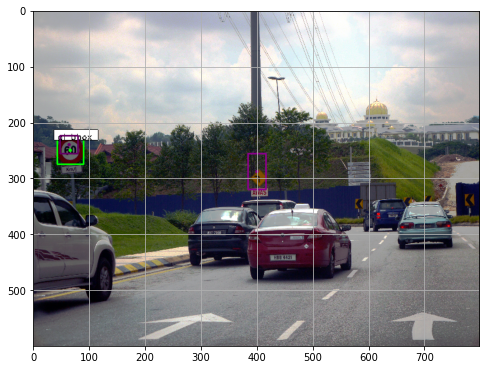

In [ ]:
print('Original image: height=%d width=%d'%(image_data['height'], image_data['width']))
print('Resized image:  height=%d width=%d C.im_size=%d'%(X.shape[1], X.shape[2], C.im_size))
print('Feature map size: height=%d width=%d C.rpn_stride=%d'%(Y[0].shape[1], Y[0].shape[2], C.rpn_stride))
print(X.shape)
print(str(len(Y))+" includes 'y_rpn_cls' and 'y_rpn_regr'")
print('Shape of y_rpn_cls {}'.format(Y[0].shape))
print('Shape of y_rpn_regr {}'.format(Y[1].shape))
print(image_data)

print('Number of positive anchors for this image: %d' % (debug_num_pos))
if debug_num_pos==0:
    gt_x1, gt_x2 = image_data['bboxes'][0]['x1']*(X.shape[2]/float(image_data['width'])), image_data['bboxes'][0]['x2']*(X.shape[2]/float(image_data['width']))
    gt_y1, gt_y2 = image_data['bboxes'][0]['y1']*(X.shape[1]/float(image_data['height'])), image_data['bboxes'][0]['y2']*(X.shape[1]/float(image_data['height']))
    gt_x1, gt_y1, gt_x2, gt_y2 = int(gt_x1), int(gt_y1), int(gt_x2), int(gt_y2)

    img = debug_img.copy()
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    color = (0, 255, 0)
    cv2.putText(img, 'gt bbox', (gt_x1, gt_y1-5), cv2.FONT_HERSHEY_DUPLEX, 0.7, color, 1)
    cv2.rectangle(img, (gt_x1, gt_y1), (gt_x2, gt_y2), color, 2)
    cv2.circle(img, (int((gt_x1+gt_x2)/2), int((gt_y1+gt_y2)/2)), 3, color, -1)

    plt.grid()
    plt.imshow(img)
    plt.show()
else:
    cls = Y[0][0]
    pos_cls = np.where(cls==1)
    print(pos_cls)
    regr = Y[1][0]
    pos_regr = np.where(regr==1)
    print(pos_regr)
    print('y_rpn_cls for possible pos anchor: {}'.format(cls[pos_cls[0][0],pos_cls[1][0],:]))
    print('y_rpn_regr for positive anchor: {}'.format(regr[pos_regr[0][0],pos_regr[1][0],:]))

    gt_x1, gt_x2 = image_data['bboxes'][0]['x1']*(X.shape[2]/float(image_data['width'])), image_data['bboxes'][0]['x2']*(X.shape[2]/float(image_data['width']))
    gt_y1, gt_y2 = image_data['bboxes'][0]['y1']*(X.shape[1]/float(image_data['height'])), image_data['bboxes'][0]['y2']*(X.shape[1]/float(image_data['height']))
    gt_x1, gt_y1, gt_x2, gt_y2 = int(gt_x1), int(gt_y1), int(gt_x2), int(gt_y2)

    img = debug_img.copy()
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    color = (0, 255, 0)
    
    cv2.rectangle(img, (gt_x1, gt_y1), (gt_x2, gt_y2), color, 2)
    cv2.circle(img, (int((gt_x1+gt_x2)/2), int((gt_y1+gt_y2)/2)), 3, color, -1)

    # Add text
    textLabel = 'gt bbox'
    (retval,baseLine) = cv2.getTextSize(textLabel,cv2.FONT_HERSHEY_COMPLEX,0.5,1)
    textOrg = (gt_x1, gt_y1+5)
    cv2.rectangle(img, (textOrg[0] - 5, textOrg[1]+baseLine - 5), (textOrg[0]+retval[0] + 5, textOrg[1]-retval[1] - 5), (0, 0, 0), 2)
    cv2.rectangle(img, (textOrg[0] - 5,textOrg[1]+baseLine - 5), (textOrg[0]+retval[0] + 5, textOrg[1]-retval[1] - 5), (255, 255, 255), -1)
    cv2.putText(img, textLabel, textOrg, cv2.FONT_HERSHEY_DUPLEX, 0.5, (0, 0, 0), 1)

    # Draw positive anchors according to the y_rpn_regr
    for i in range(debug_num_pos):

        color = (100+i*(155/4), 0, 100+i*(155/4))

        idx = pos_regr[2][i*4]/4
        anchor_size = C.anchor_box_scales[int(idx/3)]
        anchor_ratio = C.anchor_box_ratios[2-int((idx+1)%3)]

        center = (pos_regr[1][i*4]*C.rpn_stride, pos_regr[0][i*4]*C.rpn_stride)
        print('Center position of positive anchor: ', center)
        cv2.circle(img, center, 3, color, -1)
        anc_w, anc_h = anchor_size*anchor_ratio[0], anchor_size*anchor_ratio[1]
        cv2.rectangle(img, (center[0]-int(anc_w/2), center[1]-int(anc_h/2)), (center[0]+int(anc_w/2), center[1]+int(anc_h/2)), color, 2)
#         cv2.putText(img, 'pos anchor bbox '+str(i+1), (center[0]-int(anc_w/2), center[1]-int(anc_h/2)-5), cv2.FONT_HERSHEY_DUPLEX, 0.5, color, 1)

print('Green bboxes is ground-truth bbox. Others are positive anchors')
plt.figure(figsize=(8,8))
plt.grid()
plt.imshow(img)
plt.show()

# Train RPN

### Build RPN Model

In [ ]:
# set input shape
input_shape_img = (None, None, 3)

img_input = Input(shape=input_shape_img)
roi_input = Input(shape=(None, 4))

# create rpn model here
# define the base network (resnet here, can be VGG, Inception, etc)
shared_layers = nn_base(img_input, trainable=True)

# define the RPN, built on the base layers
# rpn outputs regression and cls
num_anchors = len(C.anchor_box_scales) * len(C.anchor_box_ratios)
rpn = rpn(shared_layers, num_anchors)

model_rpn = Model(img_input, rpn[:2])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.



In [ ]:
#load weights from pretrain
try:
	print('loading weights from {}'.format(C.base_rpn_weights))
	model_rpn.load_weights(C.base_rpn_weights, by_name=True)
	print("loaded weights!")
except:
	print('Could not load pretrained model weights. Weights can be found in the keras application folder \
		https://github.com/fchollet/keras/tree/master/keras/applications')


loading weights from /content/drive/My Drive/Colab Notebooks/TA/frcnn-from-scratch-with-keras/pretrain/resnet50_weights_tf_dim_ordering_tf_kernels.h5
loaded weights!


In [ ]:
# compile model
optimizer = Adam(lr=1e-5)
model_rpn.compile(optimizer=optimizer, loss=[rpn_loss_cls(num_anchors), rpn_loss_regr(num_anchors)])
model_rpn.summary()

# write training misc here
epoch_length = 500
num_epochs = 20
iter_num = 0


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9472        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, None, None, 6 256         conv1[0][0]                      
____________________________________________________________________________________________

## Start RPN Training

In [ ]:
losses = np.zeros((epoch_length, 5))
rpn_accuracy_rpn_monitor = []
rpn_accuracy_for_epoch = []
start_time = time.time()

best_loss = np.Inf

class_mapping_inv = {v: k for k, v in class_mapping.items()}
print('Starting training')

vis = True

filepath="/content/drive/My Drive/Colab Notebooks/TA/frcnn-from-scratch-with-keras/models/rpn/rpn.config_1."+C.network+".weights.{epoch:02d}-{loss:.2f}.hdf5"
print(filepath)
Callbacks=keras.callbacks.ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, save_weights_only=True, mode='auto', period=1)
callback=[Callbacks]
if len(val_imgs) == 0:
    # assuming you don't have validation data
    history = model_rpn.fit(data_gen_train,
                    epochs=num_epochs, steps_per_epoch = epoch_length, callbacks=callback)
    loss_history = history.history["loss"]
else:
    history = model_rpn.fit(data_gen_train,
                    epochs=num_epochs, validation_data=data_gen_val,
                    steps_per_epoch=epoch_length, callbacks=callback, validation_steps=100)
    loss_history = history.history["val_loss"]
    train_loss_history = history.history["loss"]

Starting training
/content/drive/My Drive/Colab Notebooks/TA/frcnn-from-scratch-with-keras/models/rpn/rpn.config_1.resnet50.weights.{epoch:02d}-{loss:.2f}.hdf5

Epoch 1/20
500/500 [==============================] - 464s 929ms/step - loss: 2.8422 - rpn_out_class_loss: 2.6522 - rpn_out_regress_loss: 0.1900 - val_loss: 0.0991 - val_rpn_out_class_loss: 1.7598 - val_rpn_out_regress_loss: 0.1302

Epoch 00001: loss improved from inf to 2.84218, saving model to /content/drive/My Drive/Colab Notebooks/TA/frcnn-from-scratch-with-keras/models/rpn/rpn.config_1.resnet50.weights.01-2.84.hdf5
Epoch 2/20
500/500 [==============================] - 434s 869ms/step - loss: 1.5019 - rpn_out_class_loss: 1.3476 - rpn_out_regress_loss: 0.1542 - val_loss: 0.1981 - val_rpn_out_class_loss: 0.9212 - val_rpn_out_regress_loss: 0.1215

Epoch 00002: loss improved from 2.84218 to 1.50185, saving model to /content/drive/My Drive/Colab Notebooks/TA/frcnn-from-scratch-with-keras/models/rpn/rpn.config_1.resnet50.weights.

In [ ]:
numpy_loss_history = np.array(loss_history)
numpy_train_loss_history = np.array(train_loss_history)
np.savetxt("/content/drive/My Drive/Colab Notebooks/TA/frcnn-from-scratch-with-keras/models/rpn/"+C.network+"_rpn_val_loss_history_config_1.txt", numpy_loss_history, delimiter=",")
np.savetxt("/content/drive/My Drive/Colab Notebooks/TA/frcnn-from-scratch-with-keras/models/rpn/"+C.network+"_rpn_train_loss_history_config_1.txt", numpy_train_loss_history, delimiter=",")

# Train CNN

### Build Whole CNN Model

In [ ]:
input_shape_img = (None, None, 3)

img_input = Input(shape = input_shape_img)
roi_input = Input(shape = (None, 4))

# define the base network (resnet here, can be VGG, Inception, etc)
shared_layers = nn_base(img_input, trainable = True)

# define the RPN, built on the base layers
num_anchors = len(C.anchor_box_scales) * len(C.anchor_box_ratios)
rpn = rpn(shared_layers, num_anchors)

classifier = classifier(shared_layers, roi_input, C.num_rois, nb_classes = len(classes_count), trainable = True)

model_rpn = Model(img_input, rpn[:2])
model_classifier = Model([img_input, roi_input], classifier)

# this is a model that holds both the RPN and the classifier, used to load/save weights for the models
model_all = Model([img_input, roi_input], rpn[:2] + classifier)


Instructions for updating:
If using Keras pass *_constraint arguments to layers.




In [ ]:
# load pretrained weights
try:
    print('loading weights from {}'.format(C.base_net_weights))
    model_rpn.load_weights(C.base_net_weights, by_name=True)
    model_classifier.load_weights(C.base_net_weights, by_name=True)
except:
    print('Could not load pretrained model weights. Weights can be found in the keras application folder \
		https://github.com/fchollet/keras/tree/master/keras/applications')
	
# may use this to resume from rpn models or previous training. specify either rpn or frcnn model to load
if os.path.isfile(C.model_path):
    print("loading previous model from ", C.model_path)
    model_rpn.load_weights(C.model_path, by_name=True)
    model_classifier.load_weights(C.model_path, by_name=True)
    
    #if continuation, load history
    record_df = pd.read_csv(record_path)
    
    r_mean_overlapping_bboxes = record_df['mean_overlapping_bboxes']
    r_class_acc = record_df['class_acc']
    r_loss_rpn_cls = record_df['loss_rpn_cls']
    r_loss_rpn_regr = record_df['loss_rpn_regr']
    r_loss_class_cls = record_df['loss_class_cls']
    r_loss_class_regr = record_df['loss_class_regr']
    r_curr_loss = record_df['curr_loss']
    r_elapsed_time = record_df['elapsed_time']

    print('Already train %d x 500 batches' % (len(record_df)))
    
elif rpn_weight_path is not None:
    try:
      print("First time training with pretrained RPN.")
      print("loading RPN weights from ", rpn_weight_path)
      model_rpn.load_weights(rpn_weight_path, by_name=True)
      print("weights loaded.")
      # Create the record.csv file to record losses, acc and mAP
      record_df = pd.DataFrame(
          columns=['mean_overlapping_bboxes', 'class_acc', 'val_class_acc', 'loss_rpn_cls', 'loss_rpn_regr', 'val_loss_rpn_cls', 'val_loss_rpn_regr', 'loss_class_cls', 'loss_class_regr', 'val_loss_class_cls', 'val_loss_class_regr', 'curr_loss', 'val_curr_loss', 'elapsed_time'])
    except:
      print("Could not load pretrained weights")
      print("First time training w/o pretrained RPN.")
      # Create the record.csv file to record losses, acc and mAP
      record_df = pd.DataFrame(
          columns=['mean_overlapping_bboxes', 'class_acc', 'val_class_acc', 'loss_rpn_cls', 'loss_rpn_regr', 'val_loss_rpn_cls', 'val_loss_rpn_regr', 'loss_class_cls', 'loss_class_regr', 'val_loss_class_cls', 'val_loss_class_regr', 'curr_loss', 'val_curr_loss', 'elapsed_time'])    
else:
    print("First time training w/o pretrained RPN.")
    # Create the record.csv file to record losses, acc and mAP
    record_df = pd.DataFrame(
        columns=['mean_overlapping_bboxes', 'class_acc', 'val_class_acc', 'loss_rpn_cls', 'loss_rpn_regr', 'val_loss_rpn_cls', 'val_loss_rpn_regr', 'loss_class_cls', 'loss_class_regr', 'val_loss_class_cls', 'val_loss_class_regr', 'curr_loss', 'val_curr_loss', 'elapsed_time'])


loading weights from /content/drive/My Drive/Colab Notebooks/TA/frcnn-from-scratch-with-keras/pretrain/resnet50_weights_tf_dim_ordering_tf_kernels.h5
loading previous model from  /content/drive/My Drive/Colab Notebooks/TA/frcnn-from-scratch-with-keras/models/config_3/Resnet.sgd.1e-3.EMTD.hdf5
Already train 14 x 500 batches


In [ ]:
optimizers = "sgd"
learning_rate = 1e-3
# optimizer setup
if optimizers.lower() == "sgd":
    print("Using SGD as optimizer")
    optimizer = SGD(learning_rate=learning_rate)
    optimizer_classifier = SGD(learning_rate=learning_rate)
elif optimizers.lower() == "adam":
    print("Using Adam as optimizer")
    optimizer = Adam(lr=learning_rate)
    optimizer_classifier = Adam(lr=learning_rate)
else:
    print("Optimizer not supported. Choose Adam or SGD.")

# compile the model AFTER loading weights!
model_rpn.compile(optimizer=optimizer, loss=[rpn_loss_cls(num_anchors), rpn_loss_regr(num_anchors)])
model_classifier.compile(optimizer=optimizer_classifier, loss=[class_loss_cls, class_loss_regr(len(classes_count)-1)], metrics={'dense_class_{}'.format(len(classes_count)): 'accuracy'})
model_all.compile(optimizer='sgd', loss='mae')
model_all.summary()


Using SGD as optimizer
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9472        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, None, None, 6 256         conv1[0][0]                      
_____________________________________________________________________

In [ ]:
#Training Settings
epoch_length = 500
num_epochs = 6
iter_num = 0

#Epoch changes if previous training is done
total_epochs = len(record_df) + num_epochs
r_epochs = len(record_df)

#Best loss changes if previous training is done
if len(record_df)==0:
    best_loss = np.Inf
else:
    best_loss = np.min(r_curr_loss)

losses = np.zeros((epoch_length, 5))
rpn_accuracy_rpn_monitor = []
rpn_accuracy_for_epoch = []
start_time = time.time()

# Validation #########################
val_losses = np.zeros((epoch_length, 5))
val_rpn_accuracy_rpn_monitor = []
val_rpn_accuracy_for_epoch = []
######################################


## Start Training

In [ ]:

class_mapping_inv = {v: k for k, v in class_mapping.items()}
print('Starting training')

vis = True
prog_start_time = time.time()

for epoch_num in range(num_epochs):
	progbar = generic_utils.Progbar(epoch_length)
	print('Epoch {}/{}'.format(r_epochs + 1, total_epochs))
	r_epochs += 1
    
	# costumize learning rate
	# if epoch_num == 3 and rpn_weight_path is not None:
	# 	K.set_value(model_rpn.optimizer.lr, learning_rate)
	# 	K.set_value(model_classifier.optimizer.lr, learning_rate)
	
	while True:
		try:
			if len(rpn_accuracy_rpn_monitor) == epoch_length and C.verbose:
			    mean_overlapping_bboxes = float(sum(rpn_accuracy_rpn_monitor))/len(rpn_accuracy_rpn_monitor)
			    rpn_accuracy_rpn_monitor = []
			    val_rpn_accuracy_rpn_monitor = []
			    print('Average number of overlapping bounding boxes from RPN = {} for {} previous iterations'.format(mean_overlapping_bboxes, epoch_length))
			    if mean_overlapping_bboxes == 0:
			      print('RPN is not producing bounding boxes that overlap the ground truth boxes. Check RPN settings or keep training.')
			
			####################################
			# TRAINING 
			####################################
			
			X, Y, img_data = next(data_gen_train)

			loss_rpn = model_rpn.train_on_batch(X, Y)

			P_rpn = model_rpn.predict_on_batch(X)
			
			R = rpn_to_roi(P_rpn[0], P_rpn[1], C, K.common.image_dim_ordering(), use_regr=True, overlap_thresh=0.7, max_boxes=300)
			# note: calc_iou converts from (x1,y1,x2,y2) to (x,y,w,h) format
			X2, Y1, Y2, IouS = calc_iou(R, img_data, C, class_mapping)

			if X2 is None:
			    rpn_accuracy_rpn_monitor.append(0)
			    rpn_accuracy_for_epoch.append(0)
			    continue

			neg_samples = np.where(Y1[0, :, -1] == 1)
			pos_samples = np.where(Y1[0, :, -1] == 0)

			if len(neg_samples) > 0:
			    neg_samples = neg_samples[0]
			else:
			    neg_samples = []

			if len(pos_samples) > 0:
			    pos_samples = pos_samples[0]
			else:
			    pos_samples = []
			
			rpn_accuracy_rpn_monitor.append(len(pos_samples))
			rpn_accuracy_for_epoch.append((len(pos_samples)))

			if C.num_rois > 1:
			    if len(pos_samples) < C.num_rois//2:
                                selected_pos_samples = pos_samples.tolist()
			    else:
                                selected_pos_samples = np.random.choice(pos_samples, C.num_rois//2, replace=False).tolist()
			    try:
                                selected_neg_samples = np.random.choice(neg_samples, C.num_rois - len(selected_pos_samples), replace=False).tolist()
			    except:
                                selected_neg_samples = np.random.choice(neg_samples, C.num_rois - len(selected_pos_samples), replace=True).tolist()
			    sel_samples = selected_pos_samples + selected_neg_samples
			else:
			    # in the extreme case where num_rois = 1, we pick a random pos or neg sample
			    selected_pos_samples = pos_samples.tolist()
			    selected_neg_samples = neg_samples.tolist()
			    if np.random.randint(0, 2):
                                sel_samples = random.choice(neg_samples)
			    else:
                                sel_samples = random.choice(pos_samples)

			loss_class = model_classifier.train_on_batch([X, X2[:, sel_samples, :]], [Y1[:, sel_samples, :], Y2[:, sel_samples, :]])

			losses[iter_num, 0] = loss_rpn[1]
			losses[iter_num, 1] = loss_rpn[2]

			losses[iter_num, 2] = loss_class[1]
			losses[iter_num, 3] = loss_class[2]
			losses[iter_num, 4] = loss_class[3]

			#iter_num += 1 #progbar moved to after validation
			
			####################################
			# VALIDATION
			####################################
			
			X, Y, img_data = next(data_gen_val)

			val_loss_rpn = model_rpn.test_on_batch(X, Y)

			P_rpn = model_rpn.predict_on_batch(X)
			R = rpn_to_roi(P_rpn[0], P_rpn[1], C, K.common.image_dim_ordering(), use_regr=True, overlap_thresh=0.7, max_boxes=300)
			# note: calc_iou converts from (x1,y1,x2,y2) to (x,y,w,h) format
			X2, Y1, Y2, IouS = calc_iou(R, img_data, C, class_mapping)

			if X2 is None:
			    val_rpn_accuracy_rpn_monitor.append(0)
			    val_rpn_accuracy_for_epoch.append(0)
			    continue

			neg_samples = np.where(Y1[0, :, -1] == 1)
			pos_samples = np.where(Y1[0, :, -1] == 0)

			if len(neg_samples) > 0:
			    neg_samples = neg_samples[0]
			else:
			    neg_samples = []

			if len(pos_samples) > 0:
			    pos_samples = pos_samples[0]
			else:
			    pos_samples = []
			
			val_rpn_accuracy_rpn_monitor.append(len(pos_samples))
			val_rpn_accuracy_for_epoch.append((len(pos_samples)))

			if C.num_rois > 1:
			    if len(pos_samples) < C.num_rois//2:
                                selected_pos_samples = pos_samples.tolist()
			    else:
                                selected_pos_samples = np.random.choice(pos_samples, C.num_rois//2, replace=False).tolist()
			    try:
                                selected_neg_samples = np.random.choice(neg_samples, C.num_rois - len(selected_pos_samples), replace=False).tolist()
			    except:
                                selected_neg_samples = np.random.choice(neg_samples, C.num_rois - len(selected_pos_samples), replace=True).tolist()
			    sel_samples = selected_pos_samples + selected_neg_samples
			else:
			    # in the extreme case where num_rois = 1, we pick a random pos or neg sample
			    selected_pos_samples = pos_samples.tolist()
			    selected_neg_samples = neg_samples.tolist()
			    if np.random.randint(0, 2):
                                sel_samples = random.choice(neg_samples)
			    else:
                                sel_samples = random.choice(pos_samples)

			val_loss_class = model_classifier.test_on_batch([X, X2[:, sel_samples, :]], [Y1[:, sel_samples, :], Y2[:, sel_samples, :]])

			val_losses[iter_num, 0] = val_loss_rpn[1]
			val_losses[iter_num, 1] = val_loss_rpn[2]

			val_losses[iter_num, 2] = val_loss_class[1]
			val_losses[iter_num, 3] = val_loss_class[2]
			val_losses[iter_num, 4] = val_loss_class[3]
			
			iter_num += 1
			
			progbar.update(iter_num, [('rpn_cls', np.mean(losses[:iter_num, 0])), ('rpn_regr', np.mean(losses[:iter_num, 1])),
									  ('final_cls', np.mean(losses[:iter_num, 2])), ('final_regr', np.mean(losses[:iter_num, 3])),
                                     ("average number of objects", len(selected_pos_samples))])
			
			if iter_num == epoch_length:
				loss_rpn_cls = np.mean(losses[:, 0])
				loss_rpn_regr = np.mean(losses[:, 1])
				loss_class_cls = np.mean(losses[:, 2])
				loss_class_regr = np.mean(losses[:, 3])
				class_acc = np.mean(losses[:, 4])
				
				val_loss_rpn_cls = np.mean(val_losses[:, 0])
				val_loss_rpn_regr = np.mean(val_losses[:, 1])
				val_loss_class_cls = np.mean(val_losses[:, 2])
				val_loss_class_regr = np.mean(val_losses[:, 3])
				val_class_acc = np.mean(val_losses[:, 4])

				mean_overlapping_bboxes = float(sum(rpn_accuracy_for_epoch)) / len(rpn_accuracy_for_epoch)
				val_mean_overlapping_bboxes = float(sum(val_rpn_accuracy_for_epoch)) / len(val_rpn_accuracy_for_epoch)
				
				rpn_accuracy_for_epoch = []
				val_rpn_accuracy_for_epoch = []
				
				if C.verbose:
					print('Mean number of bounding boxes from RPN overlapping ground truth boxes: {}'.format(mean_overlapping_bboxes))
					print('Classifier accuracy for bounding boxes from RPN: {}'.format(class_acc))
					print('Loss RPN classifier: {}'.format(loss_rpn_cls))
					print('Loss RPN regression: {}'.format(loss_rpn_regr))
					print('Loss Detector classifier: {}'.format(loss_class_cls))
					print('Loss Detector regression: {}'.format(loss_class_regr))
					print('Elapsed time: {}'.format(time.time() - start_time))
					
					print('Val_Mean number of bounding boxes from RPN overlapping ground truth boxes: {}'.format(val_mean_overlapping_bboxes))
					print('Val_Classifier accuracy for bounding boxes from RPN: {}'.format(val_class_acc))
					print('Val_Loss RPN classifier: {}'.format(val_loss_rpn_cls))
					print('Val_Loss RPN regression: {}'.format(val_loss_rpn_regr))
					print('Val_Loss Detector classifier: {}'.format(val_loss_class_cls))
					print('Val_Loss Detector regression: {}'.format(val_loss_class_regr))
					
				elapsed_time = (time.time() - start_time) / 60
				curr_loss = loss_rpn_cls + loss_rpn_regr + loss_class_cls + loss_class_regr
				val_curr_loss = val_loss_rpn_cls + val_loss_rpn_regr + val_loss_class_cls + val_loss_class_regr
				iter_num = 0
				start_time = time.time()

				if curr_loss < best_loss:
					print('Total loss decreased from {} to {}, saving weights'.format(best_loss,curr_loss))
						#print('Total loss decreased from {} to {}'.format(best_loss,curr_loss))
					best_loss = curr_loss
					model_all.save_weights(C.model_path)
				#model_all.save_weights(C.model_path)
                    
				new_row = {'mean_overlapping_bboxes': round(mean_overlapping_bboxes, 3),
                           'class_acc': round(class_acc, 3),
                           'val_class_acc': round(val_class_acc, 3),
                           'loss_rpn_cls': round(loss_rpn_cls, 3),
                           'loss_rpn_regr': round(loss_rpn_regr, 3),
                           'val_loss_rpn_cls': round(val_loss_rpn_cls, 3),
                           'val_loss_rpn_regr': round(val_loss_rpn_regr, 3),
                           'loss_class_cls': round(loss_class_cls, 3),
                           'loss_class_regr': round(loss_class_regr, 3),
                           'val_loss_class_cls': round(val_loss_class_cls, 3),
                           'val_loss_class_regr': round(val_loss_class_regr, 3),
                           'curr_loss': round(curr_loss, 3),
                           'val_curr_loss': round(val_curr_loss, 3),
                           'elapsed_time': round(elapsed_time, 3)}

				record_df = record_df.append(new_row, ignore_index=True)
				record_df.to_csv(record_path, index=0)

				break

		except Exception as e:
			print('Exception: {}'.format(e))
			continue

print('Training complete, exiting.')
total_time = int(time.time()-prog_start_time)
print("Trained on {} epochs in {} hr {} min".format(num_epochs, total_time//3600, (total_time%3600)//60))

Starting training
Epoch 15/20

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
 32/500 [>.............................] - ETA: 29:03 - rpn_cls: 0.1234 - rpn_regr: 0.0420 - final_cls: 0.1065 - final_regr: 0.1405 - average number of objects: 2.8125Exception: 'a' cannot be empty unless no samples are taken
Exception: 'a' cannot be empty unless no samples are taken
224/500 [============>.................] - ETA: 14:59 - rpn_cls: 0.1625 - rpn_regr: 0.0413 - final_cls: 0.1115 - final_regr: 0.1262 - average number of objects: 3.0134Exception: 'a' cannot be empty unless no samples are taken
Exception: 'a' cannot be empty unless no samples are taken
310/500 [=================>............] - ETA: 10:12 - rpn_cls: 0.1645 - rpn_regr: 0.0417 - final_cls: 0.1127 - final_regr: 0.1233 - average number of objects: 3.0290Exception: 'a' cannot be empty unless no samples are taken
Exception: 'a' cannot be empty unless no samples are taken
317/500 [===========

## Visualization

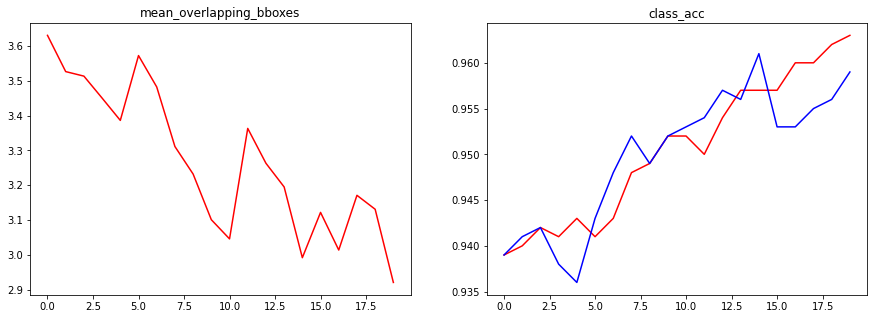

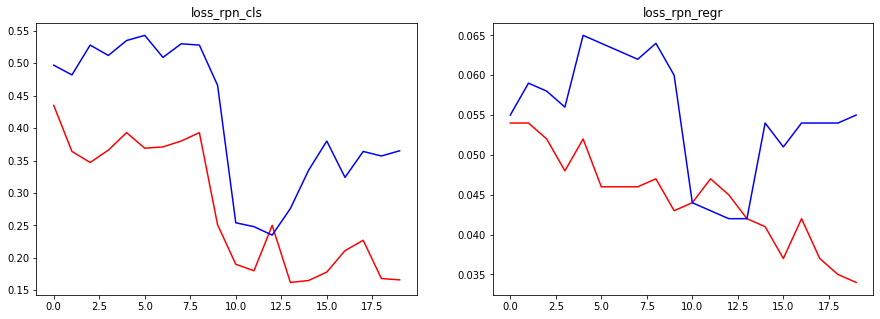

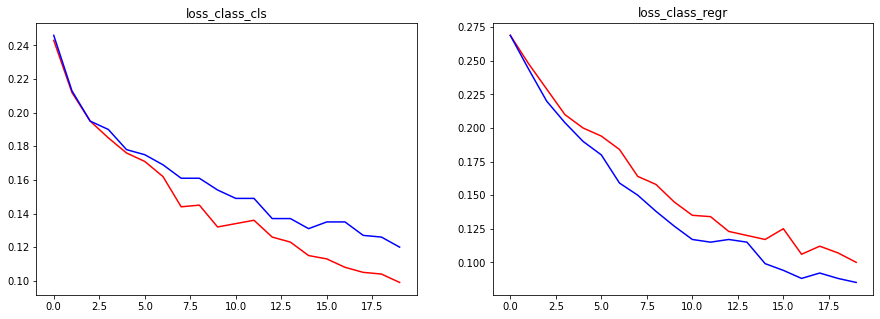

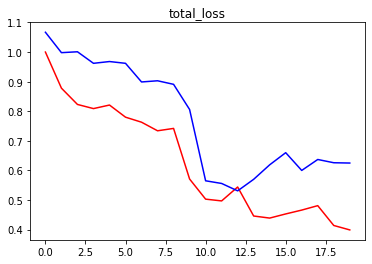

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(np.arange(0, r_epochs), record_df['mean_overlapping_bboxes'], 'r')
plt.title('mean_overlapping_bboxes')
plt.subplot(1,2,2)
plt.plot(np.arange(0, r_epochs), record_df['class_acc'], 'r', record_df['val_class_acc'], 'b')
plt.title('class_acc')
 
plt.show()
 
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(np.arange(0, r_epochs), record_df['loss_rpn_cls'], 'r', record_df['val_loss_rpn_cls'], 'b')
plt.title('loss_rpn_cls')
plt.subplot(1,2,2)
plt.plot(np.arange(0, r_epochs), record_df['loss_rpn_regr'], 'r', record_df['val_loss_rpn_regr'], 'b')
plt.title('loss_rpn_regr')
plt.show()
 
 
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(np.arange(0, r_epochs), record_df['loss_class_cls'], 'r', record_df['val_loss_class_cls'], 'b')
plt.title('loss_class_cls')
plt.subplot(1,2,2)
plt.plot(np.arange(0, r_epochs), record_df['loss_class_regr'], 'r', record_df['val_loss_class_regr'], 'b')
plt.title('loss_class_regr')
plt.show()
 
plt.plot(np.arange(0, r_epochs), record_df['curr_loss'], 'r', record_df['val_curr_loss'], 'b')
plt.title('total_loss')
plt.show()
 
# plt.figure(figsize=(15,5))
# plt.subplot(1,2,1)
# plt.plot(np.arange(0, r_epochs), record_df['curr_loss'], 'r')
# plt.title('total_loss')
# plt.subplot(1,2,2)
# plt.plot(np.arange(0, r_epochs), record_df['elapsed_time'], 'r')
# plt.title('elapsed_time')
# plt.show()
 
# plt.title('loss')
# plt.plot(np.arange(0, r_epochs), record_df['loss_rpn_cls'], 'b')
# plt.plot(np.arange(0, r_epochs), record_df['loss_rpn_regr'], 'g')
# plt.plot(np.arange(0, r_epochs), record_df['loss_class_cls'], 'r')
# plt.plot(np.arange(0, r_epochs), record_df['loss_class_regr'], 'c')
# # plt.plot(np.arange(0, r_epochs), record_df['curr_loss'], 'm')
# plt.show()